Avec les mêmes données des post Python et R nous allons entrainer deux modèles des réseau de neurones
avec Keras et TensorFlow

# importation du dataset et conversion

In [1]:
import numpy as np
import pandas as pd

dtypes_questions = {'Id':'int32', 'Score': 'int16', 'Title': 'str',
                    'Body': 'str', 'Title_raw': 'str', 'Text': 'str',
                    'Tags': 'str','Text_raw':'str'}

nrows = 20000

df_questions = pd.read_csv('df_questions_fullclean.csv',
                           usecols=dtypes_questions.keys(),
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           nrows=nrows
                          )


text_train, tag_train = df_questions.Text_raw, df_questions.Tags

Nous obtenons un boost de performance en utilisant le `texte brut` sans prétraitement passant d'un
f1 score de 82.6 %  à un f1 Score de 83.4 %, nous allons garder par la suite le texte sans prétraitement

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Nous créons un tokenizer, configuré pour ne prendre
# en compte que les 10000 mots les plus courants pour
# le texte et 100 pour les tags

tokenizer_X = Tokenizer(num_words=10000)
tokenizer_Y = Tokenizer(num_words=33)  # 33 tags limite pour un modèle à deux layers sans embedding

tokenizer_X.fit_on_texts(text_train)
tokenizer_Y.fit_on_texts(tag_train)

X_train = tokenizer_X.texts_to_matrix(text_train, mode='binary')
Y_train = tokenizer_Y.texts_to_matrix(tag_train, mode='binary')

X_train_padded = pad_sequences(X_train, padding="post")
Y_train_padded = pad_sequences(Y_train, padding="post")

label_len=len(Y_train_padded[0])

# Les posts ont été randomisés dans le prétraitement, nous utilisons les premiers 1000 post
# comme Validation et les suivants 1000 comme notre test set le restant de notre dataset
# sera utilisé pour entrainement du modèle

X_val = X_train_padded[:1000]
X_test = X_train_padded[1000:2000]
partial_X_train = X_train_padded[2000:]

Y_val = Y_train_padded[:1000]
Y_test = Y_train_padded[1000:2000]
partial_Y_train = Y_train_padded[2000:]

# Nous créons deux dictionnaires avec tous les mots trouvés dans le datasets et pas seulement
# ceux utilisés pour vectoriser les datas, nous avons donc  61769 mots pour les posts et
# 2966 mots pour les tags. Nous créons aussi un dictionnaire inversée que va nous servir pour
# traduire les prédictions du modèle

word_index_X = tokenizer_X.word_index
word_index_Y = tokenizer_Y.word_index

reverse_word_index_Y = dict (
    [(value,key) for (key,value) in word_index_Y.items()]
)
print('Found %s unique tokens in the posts.' % len(word_index_X))
print('Found %s unique tokens in the tags.' % len(word_index_Y))

Found 61769 unique tokens in the posts.
Found 2966 unique tokens in the tags.


# Modèle avec deux couches denses

In [3]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(label_len, activation='sigmoid'))

Le modèle choisi est composé de deux couches denses avec 100 unité chacun qui semblé
être bien adapté pour liste de 32 tags, lors du passage à 100 tags
le réseux n'est plus capable d'apprendre plus de deux tags, nous avons
donc augmenté le nombre d'unités des deux premières couches allant jusqu'à 5000 unités
et nous avons aussi essayé d'aumenter le nombre de couches sans succès

In [4]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [5]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

In [7]:

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(X_val, Y_val))
model.summary()

Epoch 1/30
24/24 [==============================] - 1s 16ms/step - loss: 0.3299 - acc: 0.6746 - f1_m: 0.4664 - precision_m: 0.5618 - recall_m: 0.4763 - val_loss: 0.1429 - val_acc: 0.7480 - val_f1_m: 0.5643 - val_precision_m: 0.7475 - val_recall_m: 0.4533
Epoch 2/30
24/24 [==============================] - 0s 9ms/step - loss: 0.1277 - acc: 0.7214 - f1_m: 0.5467 - precision_m: 0.7197 - recall_m: 0.4408 - val_loss: 0.1218 - val_acc: 0.7480 - val_f1_m: 0.5646 - val_precision_m: 0.7482 - val_recall_m: 0.4533

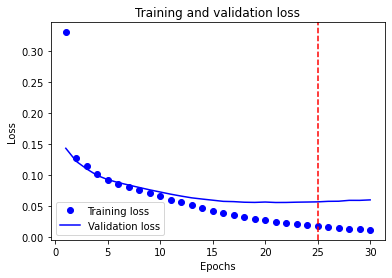

In [8]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=25,color='red',linestyle='--')

plt.show()

<Figure size 432x288 with 0 Axes>

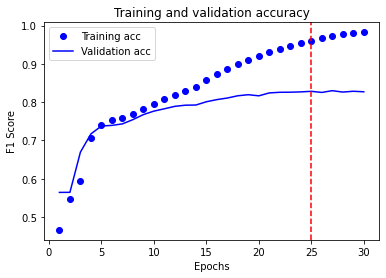

In [9]:
plt.clf()   # clear figure

f1_train = history.history['f1_m']
f1_val = history.history['val_f1_m']

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, f1_train, 'bo', label='Training acc')
plt.plot(epochs, f1_val, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.axvline(x=25,color='red',linestyle='--')

plt.show()

In [10]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.060922883450984955
Accuracy :  0.9610000252723694
f1 Score :  0.8215401768684387
precision :  0.9299389719963074
recall :  0.7382988333702087


In [11]:
Y_predict = model.predict(X_train_padded)

In [12]:
Y_predict_ones = (Y_predict>0.5).astype(int)
np.sum(Y_predict_ones,axis=0)

array([    0, 10053,  3954,   832,   628,   554,   500,   401,   348,
         312,   355,   269,   243,   245,   278,   217,   200,   223,
         203,   165,   175,   187,   173,   145,    50,   144,   107,
         143,    90,    51,   109,   118,   119])

## modèle regularisé avec early stopping

In [13]:
# On re entraine le modèle du début pour 25 epoch
model = models.Sequential()
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(label_len, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=25,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )
model.summary()

Epoch 1/25
24/24 [==============================] - 1s 15ms/step - loss: 0.3214 - acc: 0.4753 - f1_m: 0.2873 - precision_m: 0.5780 - recall_m: 0.2487 - val_loss: 0.1422 - val_acc: 0.7480 - val_f1_m: 0.5643 - val_precision_m: 0.7475 - val_recall_m: 0.4533
Epoch 2/25
24/24 [==============================] - 0s 9ms/step - loss: 0.1275 - acc: 0.7226 - f1_m: 0.5511 - precision_m: 0.7253 - recall_m: 0.4444 - val_loss: 0.1206 - val_acc: 0.7700 - val_f1_m: 0.5821 - val_precision_m: 0.7653 - val_recall_m: 0.4697

In [14]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.05570732429623604
Accuracy :  0.9660000205039978
f1 Score :  0.8243319392204285
precision :  0.9410400986671448
recall :  0.7365850806236267


In [15]:
Y_predict = model.predict(X_train_padded)

In [19]:
def vector_to_list_of_tags(vect_tag,reverse_word_ind):
    tag_list=[]
    for i in range(len(vect_tag)):
        if vect_tag[i]>0 :
            tag_list.append(reverse_word_ind.get(i,'?'))
    return tag_list

In [17]:
id_sample = 100

#print('reverse word index Y : ',reverse_word_index_Y)
print('Text before vectoring : \n',text_train[id_sample],'\n')
print('Tags before vectoring : ',tag_train[id_sample])
print('Tags vectorize matrix : ',Y_train_padded[id_sample])

sample_tag = vector_to_list_of_tags(Y_train_padded[id_sample],reverse_word_index_Y)
print('Tags vectorized : ',sample_tag)

Y_predict_ones = (Y_predict>0.5).astype(int)
sample_tag_pred = vector_to_list_of_tags(Y_predict_ones[id_sample],reverse_word_index_Y)
print('Tags predicted matrix: ',np.around(Y_predict[id_sample], decimals=1))
print('Tags predicted : ',sample_tag_pred)

Text before vectoring : 
 How to get geom_smooth() ignore my colour grouping <p>I'm trying to make a plot with fitted lines for two levels of my factor(grouped by color). I used shapes to group another variant but when I try to fit smoother, I end up with 4 lines while I only need one two lines in total (1 per color)</p>

<p>Here is the data and code I use:</p>

<pre><code>data &lt;- structure(list(K = structure(c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 
1L, 1L, 1L, 1L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 2L, 2L, 2L, 
2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L), .Label = c("2s", "4s"), class = "factor"), 
    q = c(0.12, 0.11, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 
    0.03, 0.02, 0.01, 0.12, 0.11, 0.1, 0.09, 0.08, 0.07, 0.06, 
    0.05, 0.04, 0.03, 0.02, 0.01, 0.12, 0.11, 0.1, 0.09, 0.08, 
    0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.12, 0.11, 0.1, 
    0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01), rarity = c(0.907, 
    0.92

In [18]:
np.sum(Y_predict_ones,axis=0)

array([    0, 10073,  3938,   819,   628,   542,   493,   390,   318,
         312,   355,   269,   204,   244,   280,   219,   136,   227,
         160,   112,   175,   183,   158,   129,    29,   121,    84,
         132,    59,    48,    68,    97,    58])

# Embedding

In [12]:
from keras.layers import Embedding, Flatten

tokenizer_X = Tokenizer(num_words=10000)
tokenizer_Y = Tokenizer(num_words=100)  # 100 tags posible avec embedding avec des résultats corrects

tokenizer_X.fit_on_texts(text_train)
tokenizer_Y.fit_on_texts(tag_train)

X_train = tokenizer_X.texts_to_sequences(text_train)
Y_train = tokenizer_Y.texts_to_matrix(tag_train,mode='binary')

X_train_padded = pad_sequences(X_train, padding="post",maxlen=1000)
Y_train_padded = pad_sequences(Y_train, padding="post")

#X_train_padded = X_train_padded/len(word_index_X) #normalisation

text_len = len(X_train_padded[0])
label_len=len(Y_train_padded[0])

X_val = X_train_padded[:1000]
X_test = X_train_padded[1000:2000]
partial_X_train = X_train_padded[2000:]

Y_val = Y_train_padded[:1000]
Y_test = Y_train_padded[1000:2000]
partial_Y_train = Y_train_padded[2000:]

In [20]:

model = models.Sequential()
model.add(Embedding(10000, 100, input_length=text_len))
# our activations have shape `(samples, text_len, 20)`.
# We flatten the 3D tensor of embeddings
# into a 2D tensor of shape `(samples, text_len * 100)`
model.add(Flatten())
model.add(layers.Dense(label_len, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=15,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )

model.summary()

Epoch 1/15
24/24 [==============================] - 1s 43ms/step - loss: 0.1263 - acc: 0.6841 - f1_m: 0.4532 - precision_m: 0.6821 - recall_m: 0.3651 - val_loss: 0.0788 - val_acc: 0.7480 - val_f1_m: 0.4819 - val_precision_m: 0.7475 - val_recall_m: 0.3556

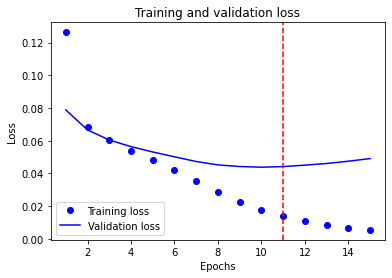

In [21]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=11,color='red',linestyle='--')

plt.show()

<Figure size 432x288 with 0 Axes>

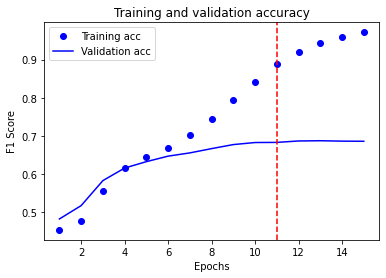

In [22]:
plt.clf()   # clear figure

f1_train = history.history['f1_m']
f1_val = history.history['val_f1_m']

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, f1_train, 'bo', label='Training acc')
plt.plot(epochs, f1_val, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.axvline(x=11,color='red',linestyle='--')

plt.show()

Nous observons un fort overfiting du modèle, nous allons ajouter
des couches dropout pour régulariser le modèle

In [23]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.048788707703351974
Accuracy :  0.9639999866485596
f1 Score :  0.695002555847168
precision :  0.9587186574935913
recall :  0.5465525388717651


## Ajout de regularisation Dropout et early stopping

In [24]:

model = models.Sequential()
model.add(Embedding(10000, 30, input_length=text_len))
model.add(layers.Dropout(0.5))
model.add(Flatten())
# ajout de la régularisation par Dropout des 50% des unités
model.add(layers.Dense(label_len, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=11,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )

model.summary()

Epoch 1/11
24/24 [==============================] - 1s 22ms/step - loss: 0.1361 - acc: 0.6901 - f1_m: 0.4513 - precision_m: 0.6848 - recall_m: 0.3508 - val_loss: 0.0878 - val_acc: 0.7480 - val_f1_m: 0.4814 - val_precision_m: 0.7472 - val_recall_m: 0.3551
Epoch 2/11
24/24 [==============================]

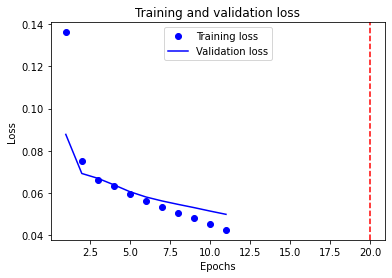

In [25]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=20,color='red',linestyle='--')

plt.show()

<Figure size 432x288 with 0 Axes>

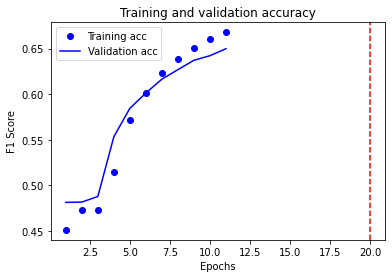

In [26]:
plt.clf()   # clear figure

f1_train = history.history['f1_m']
f1_val = history.history['val_f1_m']

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, f1_train, 'bo', label='Training acc')
plt.plot(epochs, f1_val, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.axvline(x=20,color='red',linestyle='--')

plt.show()

Nous n'observons plus un fort overfiting du modèle, après l'ajout
des couches dropout pour régulariser le modèle

In [27]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.0495058074593544
Accuracy :  0.9670000076293945
f1 Score :  0.6474922895431519
precision :  0.9629133939743042
recall :  0.4889044463634491


In [13]:
# On re entraine le modèle du début pour 20 epoch
model = models.Sequential()
model.add(Embedding(10000, 30, input_length=text_len))
# diminution de la dimension des embedings
model.add(layers.Dropout(0.5))
model.add(Flatten())
# ajout de la régularisation par Dropout des 50% des unités
model.add(layers.Dense(label_len, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc']) #,f1_m,precision_m, recall_m]) je supprime le metric pour pouvoir exporter le modele

history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )
model.summary()

Epoch 1/20
24/24 [==============================] - 3s 107ms/step - loss: 0.1354 - acc: 0.6908 - val_loss: 0.0882 - val_acc: 0.7490

In [29]:
embedd_predict = model.predict(X_test)
embedd_predict_ones = (embedd_predict>0.4).astype(int)

In [30]:
from sklearn.metrics import f1_score , precision_score, recall_score

f1_score_model        = f1_score(Y_test, embedd_predict_ones, average="micro")
precision_score_model = precision_score(Y_test, embedd_predict_ones, average="micro")
recall_score_model    = recall_score(Y_test, embedd_predict_ones, average="micro")

nb_tag = len(Y_test[0])

print("Nombre de Tags pour l'entrainement: ", nb_tag)
print("f1-score: {:.2f}".format(f1_score_model))
print("precision_score: {:.2f}".format(precision_score_model))
print("recall_score: {:.2f}".format(recall_score_model))


Nombre de Tags pour l'entrainement:  100
f1-score: 0.69
precision_score: 0.93
recall_score: 0.55


In [31]:
np.sum(embedd_predict_ones,axis=0)

array([  0, 747, 279,  49,  37,  29,  30,   9,  11,   0,  11,   0,   0,
         3,   5,   2,   0,   3,   1,   0,   1,   4,   3,   0,   0,   2,
         0,   2,   0,   0,   0,   0,   3,   0,   0,   0,   1,   0,   0,
         0,   1,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

In [32]:
np.sum(Y_test,axis=0)

array([  0, 727, 282,  62,  45,  38,  46,  35,  29,  29,  25,  27,  24,
        24,  16,  26,  14,  19,  11,  18,  15,  18,  12,   7,  13,  15,
        12,   9,  12,  16,  12,   9,  17,   7,  16,   6,   9,   9,   3,
        12,   9,   5,   8,   6,   8,   6,   5,   4,   5,   6,   7,  11,
         7,   4,   6,   8,   8,   8,   4,   7,   8,  11,  11,   7,   5,
         7,   5,   8,   7,   6,  11,   8,  10,   8,   6,   6,   6,  10,
         9,   6,   2,   5,   6,   3,   2,   6,   1,   8,   8,   4,   1,
         5,   5,   5,   6,   5,   2,   3,   5,   2])

In [33]:
embedd_predict = model.predict(partial_X_train)
embedd_predict_ones = (embedd_predict>0.5).astype(int)

In [34]:
np.sum(embedd_predict_ones,axis=0)

array([   0, 8600, 3371,  626,  489,  382,  373,  147,  218,   85,  263,
         71,   34,  149,  133,   95,   59,  137,   98,   23,  141,  126,
         96,   63,   26,   72,   44,   81,   38,   13,   42,   48,   77,
         39,   54,   33,   53,   41,   53,   59,   68,   46,   37,   40,
         12,   63,   33,   26,   19,   18,   16,   24,   61,   48,   20,
         22,   26,   12,   41,   19,   15,   42,   31,   33,    6,   23,
         36,   23,   37,   14,   11,   15,   17,   26,   24,    8,   36,
         33,    7,   11,   37,   13,   21,   18,    7,   10,   36,   14,
         10,   14,   14,    9,   22,    6,   18,   12,    9,   13,   15,
         17])

In [35]:
np.sum(partial_Y_train,axis=0)

array([   0, 8594, 3397,  726,  547,  516,  440,  373,  332,  309,  316,
        264,  278,  263,  256,  207,  206,  198,  207,  186,  169,  172,
        167,  143,  157,  135,  131,  131,  109,  129,  128,  136,  116,
        119,  116,  112,  119,  103,  116,  103,   95,  102,  104,   99,
         94,   92,   93,   94,   95,   92,   78,   86,   92,   83,   81,
         75,   76,   76,   83,   80,   77,   77,   79,   78,   73,   75,
         77,   65,   75,   72,   64,   64,   69,   64,   65,   58,   65,
         63,   64,   63,   68,   59,   60,   61,   61,   60,   63,   59,
         55,   58,   59,   55,   54,   54,   50,   55,   52,   51,   52,
         47])

In [36]:
id_sample = 900

#print('reverse word index Y : ',reverse_word_index_Y)
print('Text before vectoring : \n',text_train[id_sample],'\n')
print('Tags before vectoring : ',tag_train[id_sample])
print('Tags vectorize matrix : ',Y_train_padded[id_sample])

sample_tag = vector_to_list_of_tags(Y_train_padded[id_sample],reverse_word_index_Y)
print('Tags vectorized : ',sample_tag)

sample_tag_pred = vector_to_list_of_tags(embedd_predict_ones[id_sample],reverse_word_index_Y)
print('Tags predicted matrix: ',np.around(embedd_predict[id_sample], decimals=1))
print('Tags predicted : ',sample_tag_pred)

Text before vectoring : 
 How can I check if a keyboard modifier is pressed (Shift, Ctrl, or Alt)? <p>I am building a UI with <a href="https://en.wikipedia.org/wiki/Qt_Creator" rel="nofollow noreferrer">Qt Creator</a> and I want buttons to perform different actions with different modifiers. So I thought I could call functions with dynamic string properties that would perform the action depending on the modifier.</p>
<p>Is there a simpler way to do this?</p>
 

Tags before vectoring :  python pyqt pyqt5 pyqt4 modifier-key
Tags vectorize matrix :  [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Tags vectorized :  ['python']
Tags predicted matrix:  [0.  1.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.1 0.1 0.  0.  0.  0.  0.
 0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

## Exportation pour l'API

In [14]:
import pickle # pour exporter les modèles entrainés

pickle.dump(tokenizer_X, open('API/models/keras_tokenizer_X.pickle', 'wb')) # enregistre le modeèle de transformation X
pickle.dump(tokenizer_Y, open('API/models/keras_tokenizer_Y.pickle', 'wb')) # enregistre le modeèle de transformation X

In [15]:
model.save('API/models/keras_embedding.h5')

In [26]:
import pickle  as p# pour exporter les modèles entrainés
from tensorflow.keras.models import load_model
tokenizer_X = p.load(open('API/models/keras_tokenizer_X.pickle', 'rb'))
tokenizer_Y = p.load(open('API/models/keras_tokenizer_Y.pickle', 'rb'))
model = load_model('API/models/keras_embedding.h5')

X_train = tokenizer_X.texts_to_sequences('python')
X_train_padded = pad_sequences(X_train, padding="post",maxlen=1000)
y_predict = (model.predict(X_train_padded))
sample_tag = [y_predict.tolist()]
tag = vector_to_list_of_tags(y_predict[0], reverse_word_index_Y)
tag

['?',
 'python',
 'r',
 'django',
 'ggplot2',
 'list',
 'numpy',
 'string',
 'dataframe',
 'x',
 'matplotlib',
 '3',
 '2',
 'data',
 'dictionary',
 'regex',
 'file',
 'pandas',
 'plot',
 '7',
 'table',
 'dplyr',
 'datetime',
 'testing',
 'faq',
 'flask',
 'class',
 'sqlalchemy',
 'c',
 'function',
 'performance',
 'import',
 'models',
 'windows',
 'scipy',
 'exception',
 'arrays',
 'unicode',
 'unit',
 'csv',
 'markdown',
 'date',
 'sorting',
 'matrix',
 'variables',
 'shiny',
 'json',
 'io',
 'linux',
 'time',
 'multithreading',
 'module',
 'knitr',
 'image',
 'tkinter',
 'mysql',
 'memory',
 'formatting',
 'pip',
 'oop',
 'statistics',
 'rstudio',
 'package',
 'processing',
 'syntax',
 'algorithm',
 'virtualenv',
 'google',
 'logging',
 'line',
 'random',
 'parsing',
 'tuples',
 'xml',
 'sql',
 'html',
 'comprehension',
 'subprocess',
 'math',
 'java',
 'library',
 'path',
 'inheritance',
 'database',
 'http',
 'command',
 'imaging',
 'vector',
 'web',
 'handling',
 'loop',
 'stateme

In [14]:
import h5py


AttributeError: 'Tokenizer' object has no attribute 'save'

# Utilisation d'un embedding pré entrainé Glove
Nous avons aussi testé l'embedding pre-entrainé Glove, mais les resultats ne sont pas meilleures que l'embedding entrainé avec le modèle

In [39]:
import os
# fichier téléchargé de https://nlp.stanford.edu/projects/glove/
glove_dir = 'embedding/glove.6B/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [40]:
max_words = 10000
embedding_dim = 50 # dimension du embedding importé glove.6B.50d.txt

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index_X.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [41]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(10000, embedding_dim, input_length=text_len))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(label_len, activation='sigmoid'))
model.summary()

# charger l'embedding entrainé
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])


history = model.fit(partial_X_train,
                    partial_Y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, Y_val),
                    )

model.save_weights('pre_trained_glove_model.h5')


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 50)          500000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               6400128   
_________________________________________________________________
dense_10 (Dense)             (None, 100)               12900     
Total params: 6,913,028
Trainable params: 6,913,028
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
24/24 [==============================] - 1s 25ms/step - loss: 0.2021 - acc: 0.4633 - f1_m: 0.3625 - precision_m: 0.4837 - recall_m: 0.3894 - val_loss: 0.0986 - val_acc: 0.7850 - val_f1_m: 0.5059 - val_precision_m: 0.7810 - val_reca

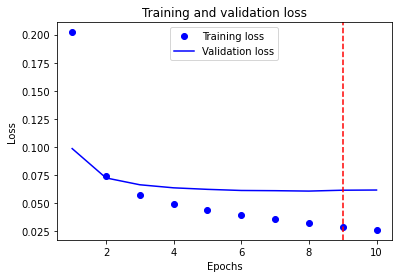

In [42]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=9,color='red',linestyle='--')

plt.show()

<Figure size 432x288 with 0 Axes>

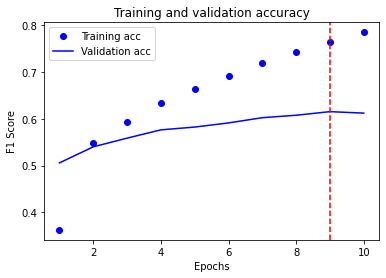

In [43]:
plt.clf()   # clear figure

f1_train = history.history['f1_m']
f1_val = history.history['val_f1_m']

fig = plt.figure()
fig.patch.set_facecolor('w')
plt.plot(epochs, f1_train, 'bo', label='Training acc')
plt.plot(epochs, f1_val, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.axvline(x=9,color='red',linestyle='--')

plt.show()

In [44]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

print('Loss : ',loss)
print('Accuracy : ',accuracy)
print('f1 Score : ',f1_score)
print('precision : ',precision)
print('recall : ',recall)

Loss :  0.061087556183338165
Accuracy :  0.9240000247955322
f1 Score :  0.6167173385620117
precision :  0.9142663478851318
recall :  0.46682459115982056
